# Skalierbare Methoden der Künstlichen Intelligenz
Charlotte Debus (charlotte.debus@kit.edu),  
Markus Götz (markus.goetz@kit.edu),  
Marie Weiel (marie.weiel@kit.edu).  
## Übung 4 am 20.12.22: Logistische Regression
In der vierten Übung beschäftigen wir uns mit der logistischen Regression und ihrer Parallelisierung. Die logistische Regression ist ein einfacher Machine-Learning-Algorithmus zur binären Klassifizierung. Er berechnet die gewichtete Summe seiner Eingaben und gibt eine Aktivierung aus, die die gewichtete Summe in das feste Intervall $\left(0,1\right)$ abbildet. Auf diese Weise können wir die Ausgabe als Wahrscheinlichkeit für die Zugehörigkeit zu einer Klasse interpretieren. Im Falle mehrerer Klassen trainiert man einfach mehrere Modelle. In dieser Übung werden wir die logistische Regression verwenden, um zu entscheiden, zu welcher von zwei Verteilungen ein Datenpunkt gehört.

### Aufgabe 1
Wie in der Vorlesung vom 01.12.22 besprochen kommt in der logistischen Regression zur numerischen Minimierung der Kostenfunktion $L$ und damit zur Bestimmung der Modellparameter $W$ typischerweise das iterative Gradientenabstiegsverfahren zum Einsatz:

$$W_{i+1}=W_i-\eta\nabla_W L$$

$\eta$ ist die sogenannte Lernrate.
Dieses Verfahren erfordert die Berechnung des Gradienten der Kostenfunktion bezüglich der Modellparameter. Der Gradient $\nabla_W L$ entspricht gerade dem Vektor mit den Komponenten $\frac{\partial L}{\partial W_j}$. 
Berechnen Sie den Gradienten der Mean-Square-Error-Kostenfunktion

$$L\left(Y,\hat{Y}\right)=MSE\left(Y,\hat{Y}\right)=\frac{1}{N}\left(Y-\hat{Y}\right)^T\left(Y-\hat{Y}\right)=\frac{1}{N}\sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2$$

für die logistische Regression mit

$$\hat{Y}=sig\left(XW\right)=\frac{1}{1+e^{-XW}}$$

per Hand. Betrachten Sie hierzu einen Datensatz $\lbrace\text{Samples, Labels}\rbrace=\lbrace X, Y\rbrace$ bestehend aus $N$ Samples mit jeweils $D$ Features, d.h. für die Daten $X\in\mathbb{R}^{N\times\left(D+1\right)}$, die Labels $Y\in\mathbb{R}^N$, die Modellparameter $W\in\mathbb{R}^{D+1}$ sowie die Modellvorhersage $\hat{Y}\in\mathbb{R}^N$ gilt (nach Anwendung des Bias Tricks):

$$X=\begin{pmatrix}
1 & x_{11} & x_{12} & \dots & x_{1D}\\
1 & x_{21} & x_{22} & \dots & x_{2D}\\
\vdots & \vdots & \vdots & \ddots & x_{1D}\\
1 & x_{N1} & x_{N2} & \dots & x_{ND}
\end{pmatrix},\quad
Y=\left(y_1, y_2, \dots, y_N\right)^T,\quad
W=\left(w_0, w_1,\dots,w_D\right)^T,\quad
\hat{Y}=sig\left(XW\right)=\left(\hat{y}_1, \hat{y}_2,\dots, \hat{y}_N\right)^T$$

Hierbei entspricht $w_0$ gerade dem Bias.
### Aufgabe 2
#### Teil a
Wir betrachten zunächst eine serielle Implementierung der logistischen Regression zur binären Klassifikation eines künstlich erstellten Datensatzes. Der Datensatz besteht zu gleichen Teilen aus Samples, die aus zwei verschiedenen Gaußverteilungen gezogen und anschließend durchmischt wurden. Untenstehend finden Sie eine beispielhafte Funktion zur Generierung solcher Daten, eine veranschaulichende Plotfunktion sowie den seriellen Code zur lokalen Ausführung im Notebook.

Wie Sie der Funktionssignatur entnehmen können, hat der Gradient-Descent-Trainingsalgorithmus `lr_train` drei Hyperparameter:

- Die Lernrate `eta` legt die Schrittgröße des Gradientenabstiegs fest.
- Die Anzahl der Epochen `epochs` legt die Anzahl der vollständigen Durchläufe durch den Trainingsdatensatz fest.
- Die Batchgröße `b` legt die Anzahl der Samples des Trainingsdatensatzes fest, die durchlaufen werden, bevor die Parameter des Modells innerhalb einer Epoche aktualisiert werden.

Analysieren Sie das Trainingsverhalten des Algorithmus für Daten bestehend aus 10 000 Samples mit je 2 Features für verschiedene Kombinationen von `epochs` und `b`. Was fällt Ihnen auf?

|`b`|  $1$ | $10$ |  $10$ | $100$ |  $100$ |  $2000$ | $10\,000$ |  $10\,000$ |  
|-----|----|----|-----|-----|------|-------|-------|--------|
| `epochs` | $20$ | $20$ | $100$ | $100$ | $1000$ | $10\,000$ | $10\,000$ | $100\,000$ |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(842424) # Fix random seed for reproducibility.

# Generate artificial data.
def generate_data(n_samples=10000, input_dim=2):
    """
    Return coordinates distributed in 2D space by two different Gaussian distributions.

    Paramters
    ---------
    n_samples : overall number of samples in dataset
    input_dim : number of features / dimension of input samples
    
    Returns
    -------
    x : np.array[n_samples, input_dim]
        coordinates
    y : np.array[n_samples]
        labels
    """
    
    half_samples = n_samples // 2 # Generate 2 equally balanced classes.
    
    # Generate the blobs.
    x1 = np.random.normal(1., 0.25, size=(half_samples, input_dim))
    x2 = np.random.normal(2., 0.30, size=(half_samples, input_dim))
    
    # Create matching labels.
    y1 = np.zeros(half_samples)
    y2 = np.ones(half_samples)
    
    data = np.concatenate((x1, x2))
    labels = np.concatenate((y1, y2))
    
    # Shuffle data to improve convergence behavior and more closely emulate real data.
    shuffled_indices = np.arange(n_samples)
    np.random.shuffle(shuffled_indices)

    return data[shuffled_indices], labels[shuffled_indices]

data, labels = generate_data()
print(f"We have {data.shape[0]} samples with {data.shape[1]} features and {labels.shape[0]} labels.")

We have 10000 samples with 2 features and 10000 labels.


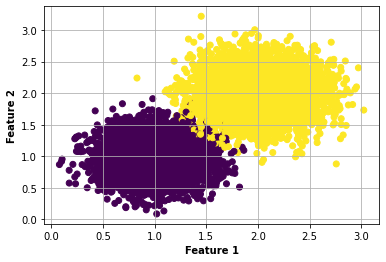

In [2]:
def plot_data(data, labels):
    """
    Plot data colored by labels.
    
    Parameters
    ----------
    data : np.array[n_samples, input_dim]
    labels : np.array[input_dim]
    """
    plt.xlabel("Feature 1", fontweight="bold")
    plt.ylabel("Feature 2", fontweight="bold")
    plt.grid()
    plt.scatter(data[:, 0], data[:, 1], c=labels, vmin=0.0, vmax=1.0)
    plt.show()

plot_data(data, labels)

In [3]:
def sigmoid(z):
    """
    Compute sigmoid.
    
    Parameters
    ----------
    z : input for sigmoid function
    
    Returns
    ----------
    sigmoid(z)
    """
    return 1.0 / (1.0 + np.exp(-z))


def lr_predict(W, X):
    """
    Return prediction of logit model for training data X using model weights W.
    
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features +1]
        Training dataset (after bias trick).
    W : array-like, shape = [n_features + 1, ]
        Parameters (after bias trick).

    W: weights to be learned. There is one weight for every input dimension plus a bias.
    X: input data where the 0th input should be 1.0 to take the bias into account in a simple dot product.
    
    Returns:
    ----------
    array-like, shape = [n_samples, ]
    Predicted activations Y_est of logit model for training dataset X,
    in this case the sigmoid of dot product of weights and input data.
    """
    return sigmoid(X @ W)


def mse(Yest, Y):
    """"
    Compute mean-square-error loss.
    
    Parameters
    ----------
    Yest : array-like, shape = [n_samples, ]
           Predictions.
    Y : array-like, shape = [n_samples, ]
        Ground-truth labels.
        
    Returns
    ----------
    loss: MSE loss
    """
    N = Y.shape[0]                            # Get number of samples in considered batch. 
    loss = (1./N) * (Y - Yest).T @ (Y - Yest) # Calculate MSE loss for considered batch.
    return loss


def lr_loss(W, X, Y):
    """
    Return the loss and the gradient with respect to the weights.
    
    Parameters
    ----------
    W : weights of the model to be learned, where weights[0] is the bias
    X : input data of shape [N x D+1], 0th element of each sample is assumed to be 1
    Y : ground-truth labels of shape [N,]
    
    Returns
    -----------
    loss : scalar mean-square-error loss for batch of samples
    gradient : np.array([weights.shape]) 
               gradient of loss with respect to weights
    """
    N = Y.shape[0]          # Get number of samples in batch.
    Yest = lr_predict(W, X) # Compute logit prediction for all samples in batch. 
    
    loss = mse(Yest, Y)     # Compute MSE loss over all samples in batch.
    # Compute gradient vector of loss w.r.t. weights.
    gradient = (-2. / N) * ((Y - Yest) * Yest * Yest * np.exp(-X @ W)).T @ X
    return loss, gradient


def lr_train(W, X, Y, epochs=100, eta=0.001, b=10):
    """
    Train the model, i.e. update the weights following the negative gradient until the model converges.
    
    Parameters
    ----------
    W : weights of the model to be learned, where weights[0] is the bias
    X : input data of shape [N x D+1], where each sample's 0th element is assumed to be 1 for bias trick
    Y : ground-truth labels of shape [N,]
    epochs : number of epochs to be trained
    eta : learning rate
    b : batch size
    
    Returns
    -----------
    weights : trained weights
    """
    N = Y.shape[0] # Determine number of samples in batch.
    Nb = N // b    # Determine number of full batches in data (drop last).
    print(f"Data is divided into {Nb} batches.")
    
    for epoch in range(epochs): # Loop over epochs.
    # The number of epochs is a gradient-descent hyperparameter 
    # that controls the number of complete passes through the train set.
    # The batch size is a gradient-descent hyperparameter 
    # that controls the number of training samples to work through before the 
    # model’s internal parameters are updated.
    
        loss_sum = 0.0 # Initiate loss for each epoch.
        accuracy = 0.0 # Initiate accuracy for each epoch.
        
        for nb in range(Nb):
            x = X[nb * b:(nb + 1) * b]
            y = Y[nb * b:(nb + 1) * b]
            loss, gradient = lr_loss(W, x, y)
            loss_sum += loss
            
            corr = np.sum((lr_predict(W, x) + 0.5).astype(int) == y)
            accuracy += corr
            W -= eta * gradient

        # Calculate loss + accuracy after each epoch.
        loss_sum /= Nb
        accuracy /= N
        accuracy *= 100
        
        # Print every tenth epoch the training status.
        if epoch % 10 == 0:
            print('Epoch: {:2}, Loss: {:.5f}, Accuracy: {}'.format(epoch, loss_sum, accuracy))
    return W

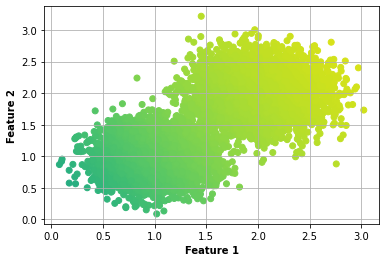

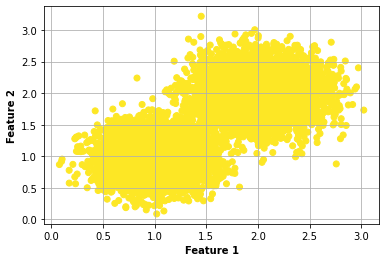

Data is divided into 1000 batches.
Epoch:  0, Loss: 0.27148, Accuracy: 50.0
Epoch: 10, Loss: 0.18923, Accuracy: 64.34
Epoch: 20, Loss: 0.15813, Accuracy: 89.74
Epoch: 30, Loss: 0.13434, Accuracy: 96.48
Epoch: 40, Loss: 0.11615, Accuracy: 98.11
Epoch: 50, Loss: 0.10208, Accuracy: 98.88
Epoch: 60, Loss: 0.09103, Accuracy: 99.16
Epoch: 70, Loss: 0.08217, Accuracy: 99.36
Epoch: 80, Loss: 0.07496, Accuracy: 99.4
Epoch: 90, Loss: 0.06900, Accuracy: 99.4


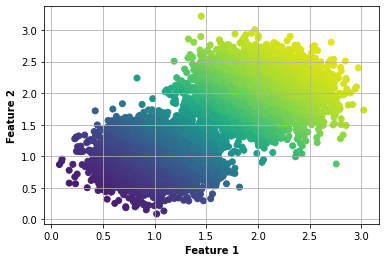

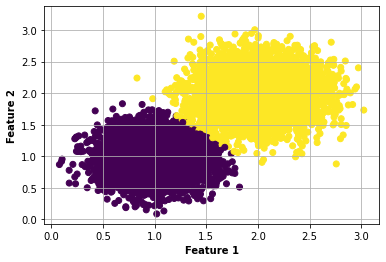

In [4]:
# Bias trick: Prepend data with 1's for additional bias dimension.
ones = np.ones((data.shape[0], 1,))
data_bt = np.hstack([ones, data])

weights = np.random.rand(data_bt.shape[1]) # Initialize model parameters randomly.

# Before training.
plot_data(data, lr_predict(weights, data_bt))
plot_data(data, np.around(lr_predict(weights, data_bt)))

# Train model.
weights = lr_train(weights, data_bt, labels, b=10, epochs=100)

# After training.
plot_data(data, lr_predict(weights, data_bt))
plot_data(data, np.around(lr_predict(weights, data_bt)))

#### Teil b
Testen Sie die serielle Implementierung auf einem CPU-basierten Knoten des bwUniClusters. 

- Erstellen Sie dazu ein Python-Skript basierend auf untenstehendem "Main"-Code sowie den Funktionen in der obigen Implementierung, welches Sie mithilfe eines Submit-Skripts auf dem Cluster starten.  
- Nutzen Sie die Daten und Labels in der HDF5-Datei `/pfs/work7/workspace/scratch/ku4408-VL_ScalableAI/data/logit_data_n10000_d2.h5`, die Sie in den Datensätzen `data` bzw. `labels` vorfinden. Der Datensatz enthält 10 000 Samples mit je 2 Features.
- Die zu verwendende Anzahl der Epochen sowie die Batchgröße können Sie als Command-Line-Argumente des Python-Skripts übergeben. 
- Laden Sie wie auf den vorherigen Übungsblättern die benötigten Module und aktivieren Sie Ihre virtuelle Python-Umgebung, bevor Sie das eigentliche Skript ausführen (siehe untenstehendes Submit-Skript). 

In [ ]:
import sys
import h5py
import numpy as np
np.random.seed(842424) # Fix random seed for reproducibility.

##################################
# PUT FUNCTION DEFINITIONS HERE! #
##################################

# MAIN
epochs = int(sys.argv[1])
b = int(sys.argv[2])

path = "/pfs/work7/workspace/scratch/ku4408-VL_ScalableAI/data/logit_data_n10000_d2.h5"
dset1 = "data"
dset2 = "labels"

with h5py.File(path, "r") as f:
    data = np.array(f[dset1])
    labels = np.array(f[dset2])

print(f"We have {data.shape[0]} samples with {data.shape[1]} features and {labels.shape[0]} labels.")

# Bias trick: Prepend data with 1's for additional bias dimension.
ones = np.ones((data.shape[0], 1,))
data_bt = np.hstack([ones, data])
weights = np.random.rand(data_bt.shape[1]) # Initialize model parameters randomly.
weights = lr_train(weights, data_bt, labels, b=b, epochs=epochs)

In [ ]:
#!/bin/bash

#SBATCH --job-name=logit                  # job name
#SBATCH --partition=single                # queue for the resource allocation.
#SBATCH --time=5:00                       # wall-clock time limit  
#SBATCH --mem=90000                       # memory per node
#SBATCH --cpus-per-task=40                # number of CPUs required per MPI task
#SBATCH --ntasks-per-node=1               # maximum count of tasks per node
#SBATCH --mail-type=ALL                   # Notify user by email.
#SBATCH --mail-user=u????@student.kit.edu # notification email address

module purge                                        # Unload all currently loaded modules.
module load compiler/gnu/11.2                       # Load required modules.  
module load mpi/openmpi/4.1
module load lib/hdf5/1.12.1-gnu-11.2-openmpi-4.1
source <path to your venv folder>/bin/activate      # Activate your virtual environment.

python <path to your python script>/logit.py 100 10 # Pass number of epochs + batch size 
                                                    # as command-line arguments.

### Aufgabe 3
Implementieren Sie ausgehend von obigem seriellen Code eine daten-parallele Version der logistischen Regression. Datenparallelismus bezeichnet eine Form der Parallelisierung, bei der das Training über die vorliegenden Samples in einem Batch der effektiven Batchgröße $b_\text{eff}$ parallelisiert wird.
Die Daten werden partitioniert und auf die verschiedenen Prozessoren verteilt, die diese parallel bearbeiten.
Jeder Prozessor verfügt über eine eigene Kopie des Modells und arbeitet lokal mit den jeweils vorliegenden Samples, wobei bei Bedarf mit den anderen Prozessoren kommuniziert wird, um die Kopien konsistent zu halten. Für den Gradientenabstieg bedeutet dies, dass es neben der oben erwähnten globalen effektiven Batchgröße $b_\text{eff}$ auf jedem Prozessor $p$ eine lokale Batchgröße $b_p$ ("Mini-Mini-Batch") gibt, für die gilt:

$$b_\text{eff}=\sum_{p}b_p$$

Jeder Prozessor berechnet für seine lokal vorliegenden Batches der Größe $b_p$ die Kostenfunktion sowie deren Gradient bezüglich der Gewichte. Nach Abarbeitung eines lokalen Batches müssen nun alle Prozessoren die jeweils lokal berechneten Gradienten austauschen und über diese mitteln, sodass jeder Prozessor anschließend die Gewichte seiner lokalen Modellkopie entsprechend der effektiven Batchgröße redundant und mit allen anderen Kopien konsistent aktualisieren kann. 

- Wie in den vorherigen Übungen auch laden wir dazu die Daten entlang der Sample-Achse verteilt auf die vorliegenden Prozessoren. Untenstehend finden Sie einen entsprechenden Dataloader. 
- Implementieren Sie ausgehend von den seriellen Funktionen eine daten-parallele Version des Gradientenabstiegs für die logistische Regression und testen Sie Ihren Code auf vier CPU-basierten Knoten des bwUniClusters. 
- Erstellen Sie dazu analog zu Aufgabenteil 2b ein Python-Skript sowie ein Submit-Bash-Skript (siehe auch vorherige Übungsblätter). 
- Nutzen Sie die Daten und Labels in der HDF5-Datei `/pfs/work7/workspace/scratch/ku4408-VL_ScalableAI/data/logit_data_n100000_d2.h5`, die Sie in den Datensätzen `data` bzw. `labels` vorfinden. Der Datensatz enthält 100 000 Samples mit je 2 Features.
- Trainieren Sie für $epochs = 100$ Epochen und nutzen Sie zunächst eine effektive Batchgröße von $b_\mathrm{eff}=100$. 
- Sie können diesen Datensatz ebenfalls mit Ihrer seriellen Variante der logistischen Regression auf dem Cluster klassifizieren. Vergleichen Sie die Güte des trainierten Modells für die gleiche Anzahl an Epochen $epochs = 100$ und die gleiche (effektive) Batchgröße $b_\mathrm{(eff)}=100$. Was fällt Ihnen auf? Variieren Sie gegebenenfalls die Hyperparameter Ihrer parallelen Version, sodass Sie eine vergleichbare Qualität des trainierten Modells erhalten. 

In [ ]:
import numpy as np
from mpi4py import MPI
import h5py

comm = MPI.COMM_WORLD
size = comm.size
rank = comm.rank

path = "/pfs/work7/workspace/scratch/ku4408-VL_ScalableAI/data/logit_data_n100000_d2.h5"
dset1 = "data"
dset2 = "labels"

with h5py.File(path, "r") as f:
    chunk = int(f[dset1].shape[0] / size)
    if rank == size - 1:
        data = np.array(f[dset1][rank * chunk:])
        labels = np.array(f[dset2][rank * chunk:])
    else:
        data = np.array(f[dset1][rank * chunk:(rank+1) * chunk])
        labels = np.array(f[dset2][rank * chunk:(rank+1) * chunk])

print(
    f"Rank {rank}/{size}: Local data has {data.shape[0]} samples with {data.shape[1]} features and {labels.shape[0]} labels. 0th elements are: {data[0]}, {labels[0]}"
)